In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

# Channel Analysis Example

First, let's load up the storage and load things from the storage. Before running this example, you'll need to run the preparatory script, `channel_analysis_setup.py`, which will generate the appropriate file.

In [2]:
storage = paths.Storage('channel_analysis_sim.nc', 'r')

In [3]:
cv_x = storage.cvs['xval']
cv_y = storage.cvs['yval']

Now let's quickly look at the path density, just in order to see what our channels look like.

In [4]:
%%time
path_dens = paths.PathDensityHistogram([cv_x, cv_y], (0.0, 0.0), (0.05, 0.05))
hist = path_dens.histogram([s.active[0].trajectory for s in storage.steps])

CPU times: user 4min 51s, sys: 475 ms, total: 4min 52s
Wall time: 4min 52s


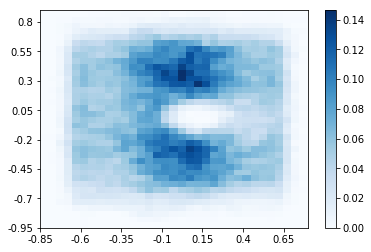

In [5]:
plotter = paths.numerics.HistogramPlotter2D(path_dens)
plotter.plot(cmap="Blues");

The hill in the potential causes the white gap centered around $(0.1, 0.0)$. Based on the path density plot, we'll take two regions that define the two channels (`hi` and `lo`, above and below that gap, respectively).

In [6]:
x_range = paths.CVDefinedVolume(collectivevariable=cv_x,
                                lambda_min=-0.2,
                                lambda_max=0.2)
y_range_hi = paths.CVDefinedVolume(collectivevariable=cv_y,
                                   lambda_min=0.05,
                                   lambda_max=1.0)
y_range_lo = paths.CVDefinedVolume(collectivevariable=cv_y,
                                   lambda_min=-1.0,
                                   lambda_max=-0.05)

In [7]:
hi_channel_vol = x_range & y_range_hi
lo_channel_vol = x_range & y_range_lo

The channels themselves are ensembles. Trajectories in the `hi` channel must have a segment with all frames in `hi_channel_vol`, and `lo` is defined analogously. With the `channels` dictionary defined, we do the analysis.

In [8]:
channels = {'hi': paths.AllInXEnsemble(hi_channel_vol),
            'lo': paths.AllInXEnsemble(lo_channel_vol)}

In [9]:
%%time
channel_analysis = paths.ChannelAnalysis(steps=storage.steps, channels=channels)

CPU times: user 1min 59s, sys: 338 ms, total: 1min 59s
Wall time: 2min


Note that it is theoretically possible for a path to enter the volumes for both the `hi` and `lo` channels. More complicated ensembles could make that more difficult (e.g., requiring a segment that starts left of the `hi_channel_vol`, enters `hi_channel_vol`, then goes to the right of it). That modification is left as an exercise to the reader. However, the channel analysis code also allows us to explicitly consider the case that multiple channels are visited. We can change that after the primary analysis by changing the `treat_multiples` attribute. Valid options are `'all'`, `'newest'`, `'oldest'`, or `'multiple'`.

In [10]:
channel_analysis.treat_multiples = 'multiple'

In [11]:
channel_analysis.switching_matrix

,hi,lo,"hi,lo"
hi,0,5,55
lo,3,0,46
"hi,lo",56,45,0


Most switching occurs through cases with the combination of `hi` and `lo` channels. Now let's plot the residence time histograms for each.

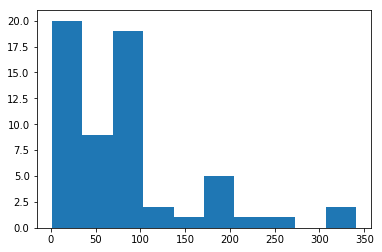

In [12]:
plt.hist(channel_analysis.residence_times['hi']);

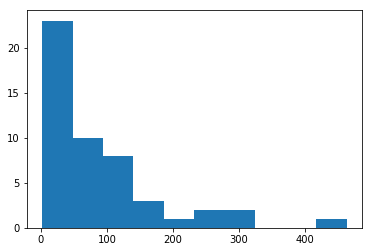

In [13]:
plt.hist(channel_analysis.residence_times['lo']);

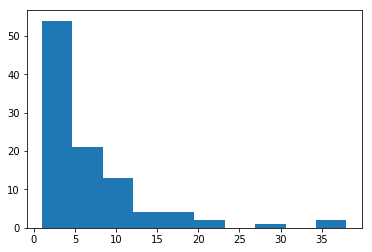

In [14]:
plt.hist(channel_analysis.residence_times['hi,lo']);

Note that all of these are at least somewhat Poissonian. What's particularly interesting, however, is that the residence times for the combination `hi,lo` are much shorter than either of the other channels, even though most of the switching involves `hi,lo`. This means that we switch into `hi,lo`, and then rapidly switch out to either `hi` or `lo`, and that's the primary mechanism of switching with these channel definitions.